In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra
from PIL import Image
import cv2
import os
import torch
import torch.nn.functional as F
from torch import nn
import itertools
from torch.utils.tensorboard import SummaryWriter
import random
import gc
import torch.optim as optim
from cebra_utils import *
import pickle

In [3]:
cebra_model_path = 'models/cebra_model_complete.pt'

data_directory = '/mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/'
neural_data_paths = [ data_directory + 'brain/' + \
                     file for file in os.listdir(data_directory + 'brain/')]

behavior_data_paths = [  data_directory + 'camera1/' + \
                     file for file in os.listdir(data_directory + 'brain/')]

dino_paths = [ data_directory + 'dino/' + \
                        file for file in os.listdir(data_directory + 'brain/')]

label_paths = list(filter(lambda x : x.endswith('.pickle') , iter(os.listdir('.'))))

neural_data_paths.sort()
behavior_data_paths.sort()
dino_paths.sort()
label_paths.sort()

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_classes = 4
solver = torch.load('models/cebra_model_complete.pt').to(device)
model_group = solver.model.eval()
prototype = nn.Sequential(nn.Linear(8, 4))
classifiers = nn.ModuleList([prototype for i in range(len(model_group))]).to(device)
for param in model_group.parameters():
    param.requires_grad = False
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(classifiers.parameters(), lr=0.0001)

In [21]:
def single_epoch(data, names, labels, model_group, criterion, optimizer, session, size = 4):
    # train the linear classifier on the labelled data
    running_loss = 0.0
    num_iter= 0
    for data, names in zip(data, names):
        # check if the data is labelled
        if names in labels:
            # do a forward pass
            output = model_group[session](torch.from_numpy(data).float().to(device))
            tiled_label = np.tile(labels[names], data.shape[0]).reshape(data.shape[0], size)
            vid_label = torch.from_numpy(tiled_label).float().to(device)
            loss = criterion(output, vid_label)
            # do a backward pass
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            num_iter += 1
            
    return (running_loss / num_iter)
            

def validation_run(data, names, labels, model_group, criterion, session, size = 4):
    # train the linear classifier on the labelled data
    running_loss = 0.0
    num_iter= 0
    for data, names in zip(data, names):
        # check if the data is labelled
        if names in labels:
            # do a forward pass
            output = model_group[session](torch.from_numpy(data).float().to(device))
            tiled_label = np.tile(labels[names], data.shape[0]).reshape(data.shape[0], size)
            vid_label = torch.from_numpy(tiled_label).float().to(device)

            loss = criterion(output, vid_label)

            running_loss += loss.item()
            num_iter += 1
            
    return (running_loss / num_iter)

In [9]:
loss_total = []
valid_loss_total = []
for i in range(len(label_paths)):
    print('Training session: ', i)
    print (label_paths[i] + ' ' + neural_data_paths[i])
    with open(label_paths[i], 'rb') as f:
        labels = pickle.load(f)

    # load the data
    data, names = import_data(neural_data_paths[i], lambda x: x, min = 0, max = 0.15)
    validation_data, validation_names  = import_data(neural_data_paths[i], lambda x: x, min = 0.15, max = 0.2)

    # generate embeddings
    embeddings = []
    for vid in data:
        single_embeddings = generate_CEBRA_embeddings(model_group, vid, i, offset = (2,3))
        embeddings.append(single_embeddings)

    validation_embeddings = []
    for vid in validation_data:
        single_embeddings = generate_CEBRA_embeddings(model_group, vid, i, offset = (2,3))
        validation_embeddings.append(single_embeddings)

    loss = []
    valid_loss = []
    for epoch in range(1500): 
        loss.append(single_epoch(embeddings, names, labels, classifiers, criterion, optimizer, i))
        valid_loss.append(validation_run(validation_embeddings, validation_names, labels, classifiers, criterion, i))
        print('Epoch: ', epoch, ' Loss: ', loss[-1], ' Validation Loss: ', valid_loss[-1])
    loss_total.append(loss)
    valid_loss_total.append(valid_loss)

Training session:  0
2020_11_17_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_17_MV1_run
Epoch:  0  Loss:  0.6184487334359878  Validation Loss:  0.6152573253427233
Epoch:  1  Loss:  0.5962467665355917  Validation Loss:  0.5965736687183381
Epoch:  2  Loss:  0.575317294676722  Validation Loss:  0.5795577168464661
Epoch:  3  Loss:  0.5562282285136634  Validation Loss:  0.5642281029905591
Epoch:  4  Loss:  0.5389036420397284  Validation Loss:  0.5504687045301709
Epoch:  5  Loss:  0.5231966219524636  Validation Loss:  0.5381375853504453
Epoch:  6  Loss:  0.5089520039434117  Validation Loss:  0.527102392911911
Epoch:  7  Loss:  0.496036524315016  Validation Loss:  0.5172453369413104
Epoch:  8  Loss:  0.48433472124321203  Validation Loss:  0.508454800929342
Epoch:  9  Loss:  0.4737354627152755  Validation Loss:  0.5006261284862246
Epoch:  10  Loss:  0.4641343057155609  Validation Loss:  0.4936632041420255
Epoch:  11  Loss:  0.455435570947366

KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


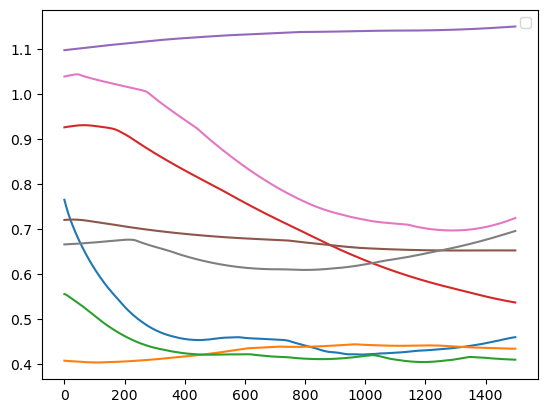

In [ ]:
# plot all the losses
for i in range(len(loss_total)):
    plt.plot(valid_loss_total[i])
plt.legend()
plt.show()

In [ ]:
torch.save(classifiers, 'models/cebra_classifier_complete.pt')

In [ ]:
model_group = torch.load('models/cebra_model_complete.pt')

In [ ]:
model_group = model_group.model.eval()

In [ ]:
true_labels = []
predicted_labels = []
for i in range(len(label_paths)):
    print('Training session: ', i)
    print (label_paths[i] + ' ' + neural_data_paths[i])

    with open(label_paths[i], 'rb') as f:
        labels = pickle.load(f)
    validation_data, names  = import_data(neural_data_paths[i], lambda x: x, min = 0.15, max = 0.2)

    validation_embeddings = []
    for vid in validation_data:
        single_embeddings = generate_CEBRA_embeddings(model_group, vid, i, offset = (2,3))
        validation_embeddings.append(single_embeddings)

    for data, names in zip(validation_embeddings, names):
        # check if the data is labelled
        if names in labels:
            # do a forward pass
            output = classifiers[i](torch.from_numpy(data).float().to('cuda'))
            true_label = np.argmax(labels[names])
            vid_label = np.argmax(np.sum(output.detach().numpy(), axis= 0))
            ## take the argmax of which class it is
            
            true_labels.append(true_label)
            predicted_labels.append(vid_label)
    



        

Training session:  0
2020_11_17_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_17_MV1_run
Training session:  1
2020_11_23_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run
Training session:  2
2020_11_2_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run
Training session:  3
2020_11_9_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_9_MV1_run
Training session:  4
2020_12_10_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_10_MV1_run
Training session:  5
2020_12_4_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run
Training session:  6
2021_1_12_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run
Training session:  7


IndexError: index 2 is out of bounds for axis 1 with size 2

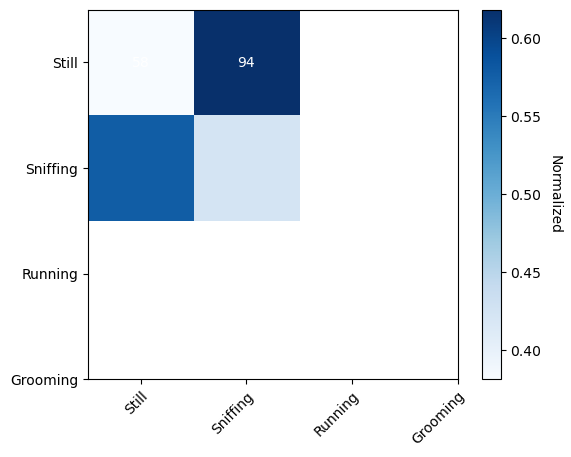

In [18]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(true_labels, predicted_labels)
# plot the confusion matrix


def plot_confusion_matrix(confusion_matrix, labels):
    # Normalize the confusion matrix
    normalized_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots()
    im = ax.imshow(normalized_matrix, cmap='Blues')

    # Set colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Normalized', rotation=-90, va="bottom")

    # Set ticks and labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Rotate the tick labels and set alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, f'{confusion_matrix[i, j]}', ha="center", va="center", color="w")

    # Set labels for the x-axis, y-axis, and title
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion Matrix')

    # Show the plot
    plt.show()

plot_confusion_matrix(confusion, ['Still', 'Sniffing', 'Running', 'Grooming'])


Training session:  0
2020_11_17_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_17_MV1_run
Generating embeddings
Epoch:  0  Loss:  0.7284747990444898  Validation Loss:  0.7173874475431781
Epoch:  1  Loss:  0.7264338016192683  Validation Loss:  0.7158622986881445
Epoch:  2  Loss:  0.7245836595888147  Validation Loss:  0.7144724071448576
Epoch:  3  Loss:  0.7228732906619109  Validation Loss:  0.7131765861037775
Epoch:  4  Loss:  0.7212600012003265  Validation Loss:  0.7119477446197618
Epoch:  5  Loss:  0.7197152951066221  Validation Loss:  0.7107676984147823
Epoch:  6  Loss:  0.7182221487759486  Validation Loss:  0.7096261160170778
Epoch:  7  Loss:  0.7167686779306542  Validation Loss:  0.7085147745220374
Epoch:  8  Loss:  0.715347644546546  Validation Loss:  0.7074295379591327
Epoch:  9  Loss:  0.7139533832735367  Validation Loss:  0.7063666396107234
Epoch:  10  Loss:  0.712582929639977  Validation Loss:  0.7053242852079108
Epoch:  11  L

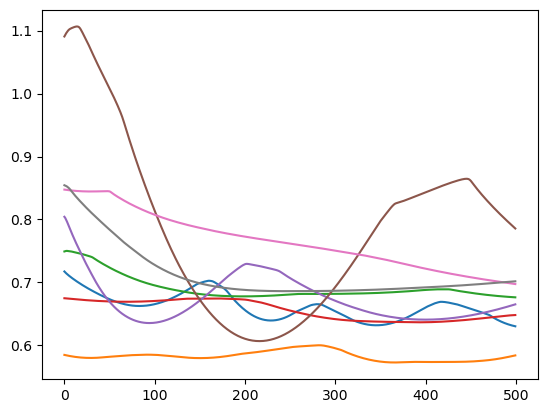

In [30]:
# Doing a training run based of off move / nomove labels
# create binary classifiers

solver = torch.load('models/cebra_model_complete.pt').to(device)
model_group = solver.model.eval()
prototype = nn.Sequential(nn.Linear(8,8), nn.GELU(), nn.Linear(8,8), nn.GELU(), nn.Linear(8, 2))
classifiers_binary = nn.ModuleList([prototype for i in range(len(model_group))]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifiers_binary.parameters(), lr=0.000001)

loss_total = []
valid_loss_total = []
for i in range(len(label_paths)):
    print('Training session: ', i)
    print (label_paths[i] + ' ' + neural_data_paths[i])

    # create and empty dict for the labels
    labels = {}

    # load the data
    data, names = import_data(neural_data_paths[i], lambda x: x, min = 0, max = 0.8)
    validation_data, validation_names  = import_data(neural_data_paths[i], lambda x: x, min = 0.8, max = 1)

    for name in names:
        if name.split('_')[0] == 'move':
            labels[name] = np.array([1,0])
        else:
            labels[name] = np.array([0,1])
    for name in validation_names:
        if name.split('_')[0] == 'move':
            labels[name] = np.array([1,0])
        else:
            labels[name] = np.array([0,1])

    print('Generating embeddings')
    # generate embeddings
    embeddings = []
    for vid in data:
        single_embeddings = generate_CEBRA_embeddings(model_group, vid, i, offset = (2,3))
        embeddings.append(single_embeddings)

    validation_embeddings = []
    for vid in validation_data:
        single_embeddings = generate_CEBRA_embeddings(model_group, vid, i, offset = (2,3))
        validation_embeddings.append(single_embeddings)

    loss = []
    valid_loss = []
    for epoch in range(500): 
        loss.append(single_epoch(embeddings, names, labels, classifiers_binary, criterion, optimizer, i, size=2))
        valid_loss.append(validation_run(validation_embeddings, validation_names, labels, classifiers_binary, criterion, i, size=2))
        print('Epoch: ', epoch, ' Loss: ', loss[-1], ' Validation Loss: ', valid_loss[-1])
    loss_total.append(loss)
    valid_loss_total.append(valid_loss)

# plot all the losses
for i in range(len(loss_total)):
    plt.plot(valid_loss_total[i])

torch.save(classifiers_binary, 'models/cebra_classifier_binary_complete.pt')

In [31]:
true_labels = []
predicted_labels = []
for i in range(len(label_paths)):
    print('Training session: ', i)
    print (label_paths[i] + ' ' + neural_data_paths[i])
    labels = {}
    validation_data, names  = import_data(neural_data_paths[i], lambda x: x, min = 0.15, max = 0.2)

    validation_embeddings = []
    for vid in validation_data:
        single_embeddings = generate_CEBRA_embeddings(model_group, vid, i, offset = (2,3))
        validation_embeddings.append(single_embeddings)

    for name in names:
        if name.split('_')[0] == 'move':
            labels[name] = np.array([1,0])
        else:
            labels[name] = np.array([0,1])

    for data, names in zip(validation_embeddings, names):
        # check if the data is labelled
        if names in labels:
            # do a forward pass
            output = classifiers_binary[i](torch.from_numpy(data).float().to('cuda'))
            true_label = np.argmax(labels[names])
            vid_label = np.argmax(np.sum(output.cpu().detach().numpy(), axis= 0))
            ## take the argmax of which class it is
            
            true_labels.append(true_label)
            predicted_labels.append(vid_label)

Training session:  0
2020_11_17_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_17_MV1_run
Training session:  1
2020_11_23_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run
Training session:  2
2020_11_2_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run
Training session:  3
2020_11_9_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_9_MV1_run
Training session:  4
2020_12_10_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_10_MV1_run
Training session:  5
2020_12_4_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run
Training session:  6
2021_1_12_MV1_runlabels.pickle /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run
Training session:  7


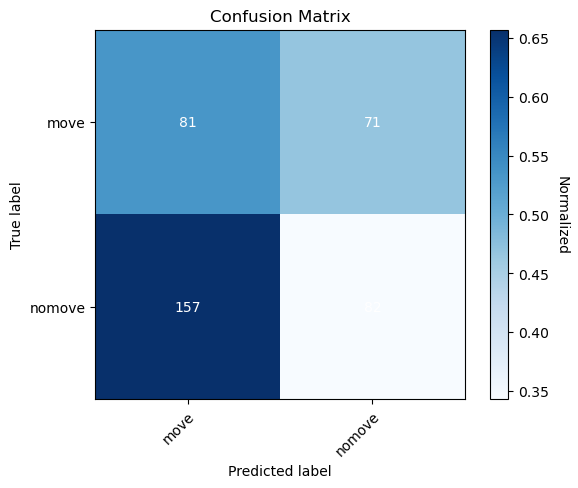

In [32]:
confusion = confusion_matrix(true_labels, predicted_labels)
plot_confusion_matrix(confusion, ['move', 'nomove'])


In [17]:
## create torch model group
model_group2 = [torch.load('models/cebra_model_complete' + path[0].split('/')[-1] + '.pt' ).model for path in neural_data_paths]


In [24]:
model_group = []
for model_name in neural_data_paths:
    model = torch.load('models/cebra_model_complete' + model_name.split('/')[-1] + '.pt' )
    model_group.append(model.model)



ModuleList(
  (0-1136): 1137 x ConvulotionalModel1(
    (net): Sequential(
      (0): ChangeOrderLayer()
      (1): Conv2d(5, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): GELU(approximate='none')
      (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): GELU(approximate='none')
      (6): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
      (7): Flatten(start_dim=1, end_dim=-1)
      (8): Linear(in_features=1024, out_features=8, bias=True)
      (9): _Norm()
      (10): Squeeze()
    )
  )
)

In [26]:
embeddings = []
name = []
valid_embeddings = []
valid_name = []
data = []
valid_data = []
for index in range(len(neural_data_paths)):
    temp_data, temp_name = import_data(neural_data_paths[index], lambda x: x, min = 0.0, max = 0.8)
    temp_valid_data, temp_valid_name = import_data(neural_data_paths[index], lambda x: x, min = 0.8, max = 1)
    data.extend(temp_data)
    valid_data.extend(temp_valid_data)
    temp_embeddings = flatten_data([generate_CEBRA_embeddings(model_group[index], x, i, (2,3)) for i, x in enumerate(temp_data)])
    temp_valid_embeddings = flatten_data([generate_CEBRA_embeddings(model_group[index], x, i, (2,3)) for i, x in enumerate(temp_valid_data)])
    embeddings.extend(temp_embeddings)
    valid_embeddings.extend(temp_valid_embeddings)
    name.extend(temp_name)
    valid_name.extend(temp_valid_name)
decoder = cebra.KNNDecoder(n_neighbors=100, metric='cosine')
labels = np.concatenate([np.ones(len(y)) * (x.split('_')[0] == 'move') for x, y in zip(name, data)])
valid_labels = np.concatenate([np.ones(len(y)) * (x.split('_')[0] == 'move') for x, y in zip(valid_name, valid_data)])
decoder.fit(embeddings, labels)
pred_labels = decoder.predict(valid_embeddings)
score = decoder.score(valid_embeddings, valid_labels)
confusion = confusion_matrix(valid_labels, np.round(pred_labels))
plot_confusion_matrix(confusion, ['move', 'nomove'])
print(score)

In [119]:
labels

array([0., 0., 0., ..., 1., 1., 1.])

Indices: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_17_MV1_run2020_11_17_MV1_runlabels.pickle
Indices: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_23_MV1_run2020_11_23_MV1_runlabels.pickle
Indices: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_2_MV1_run2020_11_2_MV1_runlabels.pickle
Indices: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_9_MV1_run2020_11_9_MV1_runlabels.pickle
Indices: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_10_MV1_run2020_12_10_MV1_runlabels.pickle
Indices: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_12_4_MV1_run2020_12_4_MV1_runlabels.pickle
Indices: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_12_MV1_run2021_1_12_MV1_runlabels.pickle
Indices: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2021_1_8_MV1_run2021_1_8_MV1_runla

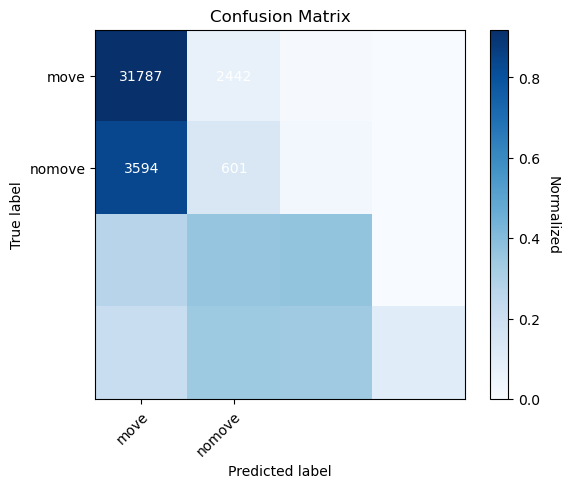

0.3869180046567824


In [ ]:
embeddings = []
valid_embeddings = []
labels = []
valid_label = []
for index in range(len(neural_data_paths)):
    print('Indices: ' +(neural_data_paths[index]) + label_paths[index])
    temp_data, temp_name = import_data(neural_data_paths[index], lambda x: x, min = 0.0, max = 0.15)
    temp_valid_data, temp_valid_name = import_data(neural_data_paths[index], lambda x: x, min = 0.15, max = 0.2)
    with open(label_paths[index], 'rb') as f:
        label_dict = pickle.load(f)
    temp_embeddings = flatten_data([generate_CEBRA_embeddings(model_group[index], x, i, (2,3)) for i, x in enumerate(temp_data)])
    temp_valid_embeddings = flatten_data([generate_CEBRA_embeddings(model_group[index], x, i, (2,3)) for i, x in enumerate(temp_valid_data)])
    embeddings.extend(temp_embeddings)
    valid_embeddings.extend(temp_valid_embeddings)
    labels.extend([np.ones(len(y)) * np.argmax(label_dict[x]) for x, y in zip(temp_name, temp_data)])
    valid_label.extend([np.ones(len(y)) * np.argmax(label_dict[x]) for x, y in zip(temp_valid_name, temp_valid_data)])
labels = np.concatenate(labels)
valid_labels = np.concatenate(valid_label)
decoder = cebra.KNNDecoder(n_neighbors=100, metric='cosine')
decoder.fit(embeddings, labels)
pred_labels = decoder.predict(valid_embeddings)
score = decoder.score(valid_embeddings, valid_labels)
confusion = confusion_matrix(valid_labels, np.round(pred_labels))
plot_confusion_matrix(confusion,  ['Still', 'Sniffing', 'Running', 'Grooming'])
print(score)

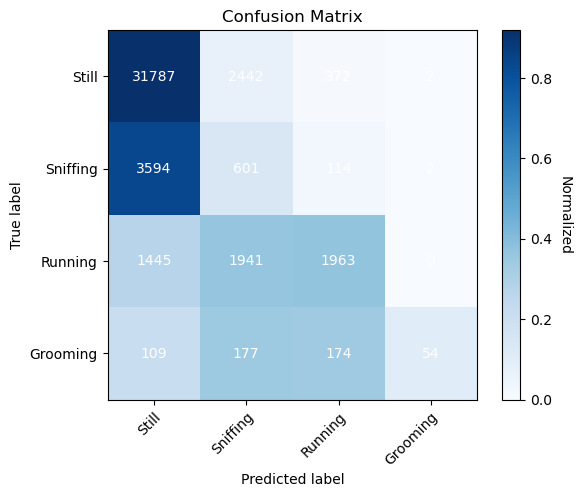

In [112]:
plot_confusion_matrix(confusion,  ['Still', 'Sniffing', 'Running', 'Grooming'])
